In [7]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd

# Load Excel File
path = '../data/Lead Generation 2.xlsx'
data = pd.read_excel(path)

# Set regression target
target = "Customer_Loyalty_Score"

# Drop target + ID
X = data.drop(columns=[target, "Customer_ID"])
y = data[target]

# Split numerical and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# ---------- MUTUAL INFORMATION ----------
mi = mutual_info_regression(X_encoded, y)
mi_series = pd.Series(mi, index=X_encoded.columns)

# ---------- PEARSON CORRELATION ----------
# correlation only works with numeric features, so we use encoded X
corr_series = X_encoded.corrwith(y)

# ---------- COMBINE INTO ONE TABLE ----------
result_table = pd.DataFrame({
    "MutualInfo": mi_series,
    "Correlation": corr_series
})

# sort by MI (or correlation if you prefer)
result_table = result_table.sort_values(by="MutualInfo", ascending=False)

print(result_table)


                                MutualInfo  Correlation
Number_of_Purchases               0.160656     0.034977
Annual_Income                     0.052098    -0.202571
Churn_Risk_Low                    0.029210     0.086297
Gender_Male                       0.011626     0.120873
Marketing_Channel_Referral        0.006526    -0.139379
Age                               0.000000    -0.020061
Marketing_Channel_Email           0.000000     0.056284
Marketing_Channel_Social Media    0.000000     0.044246
Marketing_Channel_TV              0.000000    -0.102266
Churn_Risk_Medium                 0.000000     0.047830


In [31]:
# Simple Logistic Regression implementation

from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# Load Excel File
data = pd.read_excel(path)





data["PCat"] = pd.qcut(
    data["Number_of_Purchases"],
    q=3,
    labels=["Low", "Medium", "High"]
)

data["PCat"] = pd.cut(
    data["Number_of_Purchases"],
    bins=3,
    labels=["Low", "Medium", "High"]
)

data["PCat"] = [
    "High" if p < 25 else
    "Medium" if p <= 40 else
    "Low"
    for p in data["Number_of_Purchases"]
]

print(data.head())

# Calculate Mutual Information
target = "Churn_Risk"
X = data.drop(target, axis=1)
# drop CustomerID
X = X.drop("Customer_ID", axis=1)

# Split numerical and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# One-hot encode categorical features
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

y = data[target]
mi = mutual_info_classif(X, y)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print("Mutual Information Scores:")
print(mi_series)


   Customer_ID  Age Gender  Annual_Income  Number_of_Purchases  \
0            1   56   Male          45939                   16   
1            2   69   Male          68925                   29   
2            3   46   Male          62941                    3   
3            4   32   Male          41834                   20   
4            5   60   Male          38047                   36   

   Customer_Loyalty_Score Marketing_Channel Churn_Risk    PCat  
0                0.668924                TV        Low    High  
1                0.864168       Direct Mail        Low  Medium  
2                0.230185                TV       High    High  
3                0.499193             Email       High    High  
4                0.572004       Direct Mail       High  Medium  
Mutual Information Scores:
Marketing_Channel_Email           0.147425
Marketing_Channel_Referral        0.040345
Number_of_Purchases               0.038287
PCat_Low                          0.021250
Annual_Income 

In [32]:
# We need to create a classifier for Lead Quality based on the features with high mutual information scores. 
# Needs to classify into High, Medium and Low
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X_top = pd.get_dummies(data[["PCat"]], drop_first=True)
# X_top = data[["Number_of_Purchases"]] 

X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=100000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# We want accuracy and f1 score printed out
from sklearn.metrics import accuracy_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy}")

print(f"F1 Score: {f1}")


Confusion Matrix:
[[ 6  0  0]
 [10  0  0]
 [ 4  0  0]]
Classification Report:
              precision    recall  f1-score   support

        High       0.30      1.00      0.46         6
         Low       0.00      0.00      0.00        10
      Medium       0.00      0.00      0.00         4

    accuracy                           0.30        20
   macro avg       0.10      0.33      0.15        20
weighted avg       0.09      0.30      0.14        20

Accuracy: 0.3
F1 Score: 0.13846153846153847


/Users/ludwigopulski/venvs/manim/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ludwigopulski/venvs/manim/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ludwigopulski/venvs/manim/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

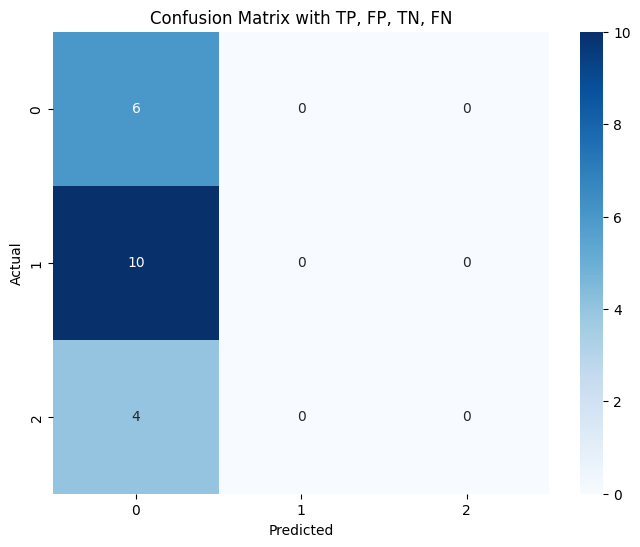

In [33]:
# Also label True Positives, False Positives, True Negatives, False Negatives on the heatmap
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with TP, FP, TN, FN')

plt.show()

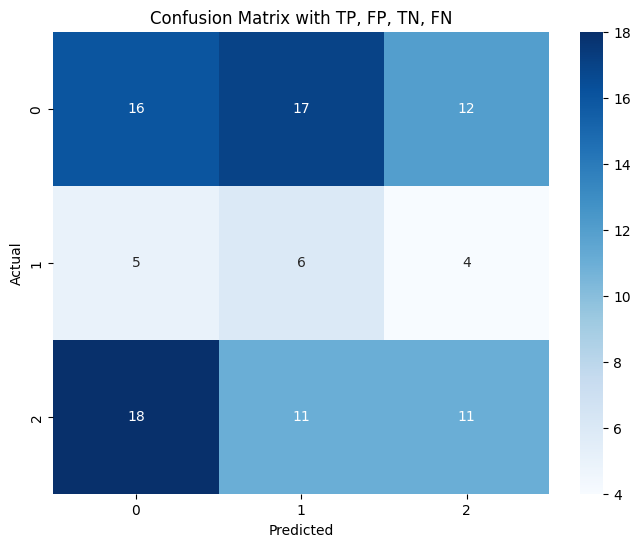

In [34]:
# Also label True Positives, False Positives, True Negatives, False Negatives on the heatmap
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
cm = confusion_matrix(data["PCat"], data["Churn_Risk"])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with TP, FP, TN, FN')

plt.show()

In [52]:
accuracy = accuracy_score(data["PCat"], data["Churn_Risk"])
print("Accuracy:", accuracy)

from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(data["PCat"], data["Churn_Risk"], average='weighted')
recall    = recall_score(data["PCat"], data["Churn_Risk"], average='weighted')
f1        = f1_score(data["PCat"], data["Churn_Risk"], average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)



Accuracy: 0.33
Precision: 0.3740489358136416
Recall: 0.33
F1 Score: 0.33950654888821197


In [36]:
data["Number_of_Purchases"].mean()

25.83

In [37]:
data["Number_of_Purchases"].median()

26.5

In [39]:
data["Number_of_Purchases"].min()


1

In [40]:
data["Number_of_Purchases"].max()

49

In [43]:
data["Number_of_Purchases"].quantile(0)

1.0

In [45]:
data["Number_of_Purchases"].quantile(0.5)

26.5

In [49]:
data["Number_of_Purchases"].quantile(0.66)

33.0

In [50]:
data["Number_of_Purchases"].quantile(0.33)

19.67

In [53]:
from sklearn.metrics import classification_report

print(
    classification_report(
        data["PCat"],
        data["Churn_Risk"],
        digits=4
    )
)


              precision    recall  f1-score   support

        High     0.4103    0.3556    0.3810        45
         Low     0.1765    0.4000    0.2449        15
      Medium     0.4074    0.2750    0.3284        40

    accuracy                         0.3300       100
   macro avg     0.3314    0.3435    0.3181       100
weighted avg     0.3740    0.3300    0.3395       100

